<a href="https://colab.research.google.com/github/mohamadnaji/Machine-Learning-Real-Estate-Price-Prediction-Lebanon/blob/main/house_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices Prediction using TensorFlow Decision Forests

## Import the library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Load the dataset


In [ ]:
# train_file_path = "/content/drive/Othercomputers/MyMonty Laptop/university M2/M2 final project/Dataset/step 3 - with spatial analysis/SELL_REAL_ESTATE_2024-09-15-2.xlsx"
train_file_path = "/content/drive/Othercomputers/MyMonty Laptop/university M2/M2 final project/Dataset/step 3 - with spatial analysis/SELL_REAL_ESTATE_2024-11-17.xlsx"
# train_file_path = "/content/drive/MyDrive/university M2/M2 final project/Dataset/step 3 - with spatial analysis/SELL_REAL_ESTATE_2024-10-29 - Copy.xlsx"
# Load the Excel file into a DataFrame
data = pd.read_excel(train_file_path)

print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (10003, 50)


## preprocess the data

In [ ]:
# Function to extract numbers
def extract_number(value):
    # Remove any non-numeric characters
    number = re.sub(r"[^\d]", "", value)
    return int(number) if number else None

# Apply the function to the 'Currency' column
data['Price'] = data['price'].apply(extract_number)
data = data.drop(columns=['price' ,'Listing Type', 'Join_Count', 'creation date',
                          'NEAR_FID', 'OBJECTID', 'TARGET_FID', 'source',
                          'source_name', 'Reference Id', 'img_src', 'description'
                          ,'NEAR_UNIVERSITY_DIST'], inplace=False)

# data = data.drop(columns=[ 'X', 'Y'])

In [ ]:
data = data.dropna(subset=['Price'])

# Assuming your DataFrame is named 'data' and the columns are 'Type' and 'Size'
data = data[data['Property Type'] == 'Apartment']
data = data[data['Floors'].isna()]
data = data[data['Bedrooms'].notna()]
data = data[data['Bathrooms'].notna()]
data = data[data['Size (m²)'] < 800]

In [ ]:
# Count the number of rows for each governorate
governorate_counts = data['governorate'].value_counts()

# Get the top 3 governorates with the highest row counts
top_3_governorates = governorate_counts.head(3).index

# Filter the data for only the top 3 governorates
data = data[data['governorate'].isin(top_3_governorates)]

# data.loc[data['governorate'] == 'Keserwan-Jbeil', 'governorate'] = 'Mont-Liban'

In [ ]:
print(data.shape)

(7204, 38)


Dropping the column that contains more than 1000 null value

In [ ]:
# Filter columns based on null value counts
columns_to_drop = data.columns[data.isnull().sum() > 1500]

# Drop columns with null value counts exceeding the threshold
data = data.drop(columns=columns_to_drop)

# # Remaining columns
data.shape

(7204, 31)

### Use data augmentation method to add more data for high prices

In [ ]:
import numpy as np
import pandas as pd

# Identify numerical, binary, and categorical features
numerical_features = data.select_dtypes(include=[np.number]).columns
binary_features = [col for col in numerical_features if data[col].nunique() == 2]
continuous_features = [col for col in numerical_features if col not in binary_features]
categorical_features = data.select_dtypes(exclude=[np.number]).columns

# Filter high-priced data (e.g., Price >= 500k) 600 1.2
high_price_data = data[data['Price'] >= 700000]

# Number of synthetic samples to generate (e.g., 50% of high-price data)
n_samples = int(1 * len(high_price_data))
print(f'Number of new samples {n_samples}')

# Generate synthetic samples with Gaussian noise for continuous features only
synthetic_samples = []
for _ in range(n_samples):
    sample = high_price_data.sample(n=1).copy()

    # Add Gaussian noise to continuous features SCALE=0.05
    noise = np.random.normal(loc=0, scale=0.05, size=len(continuous_features))
    sample[continuous_features] += sample[continuous_features] * noise

    # # Ensure X and Y columns are minimally altered (0.001 or less)
    # if 'X' in continuous_features and 'Y' in continuous_features:
    #     xy_noise = np.random.normal(loc=0, scale=0.001, size=2)  # Generate noise for X and Y
    #     sample['X'] += xy_noise[0]
    #     sample['Y'] += xy_noise[1]

    # Ensure binary features remain unchanged
    sample[binary_features] = sample[binary_features].round().clip(0, 1)

    # Append the augmented sample
    synthetic_samples.append(sample)

# Create a DataFrame from synthetic samples
augmented_high_price_data = pd.concat(synthetic_samples, ignore_index=True)

# Concatenate the augmented data with the original data
data = pd.concat([data, augmented_high_price_data], ignore_index=True)

# data = data[data['Price'] < 2000000]
data = data[data['Price'] > 30000]

integer_features = ['Bedrooms', 'Bathrooms']
data[integer_features] = np.ceil(data[integer_features]).astype(int)

print("Augmented data shape:", data.shape)

Number of new samples 993
Augmented data shape: (8183, 31)


Encoding the object features using one label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Find categorical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Initialize OneHotEncoder
encoder = LabelEncoder()

# Fit and transform the data
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
    print(col)
    print(dict(enumerate(encoder.classes_)))

Property Type
{0: 'Apartment'}
Ownership
{0: 'By Company', 1: 'By Owner', 2: nan}
Payment method
{0: 'Cash', 1: 'Cheque', 2: 'Installments', 3: 'Other', 4: nan}
Condition
{0: 'Ready to move in', 1: 'Under Construction', 2: nan}
LULC
{0: 'Banana', 1: 'Bare Rocks', 2: 'Clear Grasslands', 3: 'Clear Mixed Wooded Lands', 4: 'Clear Oaks', 5: 'Clear Pines', 6: 'Dense Informal Urban Fabric', 7: 'Dense Mixed Wooded Lands', 8: 'Dense Oaks', 9: 'Dense Pines', 10: 'Dense Urban Fabric', 11: 'Diverse Equipment', 12: 'Fruit Trees', 13: 'Green Sports Area', 14: 'Highway', 15: 'Industrial or Commercial Areas', 16: 'Low Density Urban Fabric', 17: 'Medium Density Urban Fabric', 18: 'Meium Denisty Informal Urban Fabric', 19: 'Olives', 20: 'Port Areas', 21: 'Port Basin', 22: 'Protected Agriculture', 23: 'Rocky Outcrops', 24: 'Scrubland', 25: 'Scrubland with Some Dispersed Bigger Trees', 26: 'Uran Extension and/or Construction Sites', 27: 'Urban Vacant Land'}
governorate
{0: 'Beyrouth', 1: 'Keserwan-Jbeil',

Filling null values using iterative imputer

In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer

# Identify column types
numerical_features = data.select_dtypes(include=[np.number]).columns
binary_features = [col for col in numerical_features if data[col].nunique() == 2]
integer_features = [col for col in numerical_features if col not in binary_features and pd.api.types.is_integer_dtype(data[col])]

# Apply Iterative Imputer
iterative_imputer = IterativeImputer()
df_imputed = iterative_imputer.fit_transform(data)

# Convert the imputed data back to a DataFrame
data = pd.DataFrame(df_imputed, columns=data.columns)

# Convert binary features back to 0/1
data[binary_features] = data[binary_features].round().clip(0, 1)

# Convert integer features back to integers
data[integer_features] = data[integer_features].round().astype(int)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8183 entries, 0 to 8182
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Property Type             8183 non-null   int64  
 1   Ownership                 8183 non-null   int64  
 2   Bedrooms                  8183 non-null   int64  
 3   Bathrooms                 8183 non-null   int64  
 4   Size (m²)                 8183 non-null   float64
 5   Payment method            8183 non-null   int64  
 6   Condition                 8183 non-null   int64  
 7   X                         8183 non-null   float64
 8   Y                         8183 non-null   float64
 9   Near Amenities            8183 non-null   float64
 10  Heating and Cooling       8183 non-null   float64
 11  Outdoor and Landscaping   8183 non-null   float64
 12  Security Features         8183 non-null   float64
 13  Storage and Space         8183 non-null   float64
 14  Views   

Removing outliers

In [ ]:
from sklearn.ensemble import IsolationForest

def remove_outliers_isolation_forest(data):#0.15
    iso_forest = IsolationForest(contamination=0.15, random_state=42)
    outliers = iso_forest.fit_predict(data.select_dtypes(include=np.number))
    # print(data[outliers == 1])
    return data[outliers == 1]  # Keep only inliers

data = remove_outliers_isolation_forest(data)
print(data.shape)

(6955, 31)


Select the most important features

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
# import shap
# from xgboost import XGBRegressor

# # Assuming you have loaded your data into 'data'
# X = data.drop(columns=['Price'])
# y = data['Price']

# # Standardize the data for methods that require scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Dictionary to store feature importance scores
# feature_scores = pd.DataFrame(index=X.columns)

# # 1. SelectKBest (f_regression)
# skb = SelectKBest(score_func=f_regression, k='all')
# skb.fit(X, y)
# feature_scores['SelectKBest'] = skb.scores_

# # 2. Recursive Feature Elimination (RFE) with Linear Regression
# rfe = RFE(estimator=LinearRegression(), n_features_to_select=20)
# rfe.fit(X, y)
# # Since RFE provides rankings, we convert them to importance scores (inverse of ranking)
# feature_scores['RFE'] = 1 / rfe.ranking_
# print(feature_scores['RFE'])

# # 3. Random Forest Feature Importance
# rf = RandomForestRegressor()
# rf.fit(X, y)
# feature_scores['RandomForest'] = rf.feature_importances_

# # 4. Lasso Regression
# lasso = Lasso(alpha=0.01)
# lasso.fit(X_scaled, y)
# feature_scores['Lasso'] = np.abs(lasso.coef_)

# # 5. Mutual Information
# mi = mutual_info_regression(X, y)
# feature_scores['MutualInfo'] = mi

# # 6. SHAP Values with XGBoost
# xgb = XGBRegressor()
# xgb.fit(X, y)
# explainer = shap.Explainer(xgb)
# shap_values = explainer(X)
# shap_importance = np.abs(shap_values.values).mean(axis=0)
# feature_scores['SHAP'] = shap_importance

# # Normalize scores for better comparison (0 to 1)
# feature_scores = feature_scores.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

# # Select top 20 features based on the average score across all methods
# top_features = feature_scores.mean(axis=1).nlargest(20).index

# # Filter scores for top features only
# top_feature_scores = feature_scores.loc[top_features]

# # Plot the grouped bar chart
# top_feature_scores.plot(kind='bar', figsize=(15, 8), width=0.8)
# plt.title('Feature Importance Scores Across Different Methods')
# plt.xlabel('Features')
# plt.ylabel('Normalized Importance Score')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Methods')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.feature_selection import mutual_info_regression

# # Assuming you have loaded your data into 'data'
# X = data.drop(columns=['Price'])
# y = data['Price']

# # Calculate mutual information
# mi_scores = mutual_info_regression(X, y)
# mi_scores = pd.Series(mi_scores, index=X.columns)

# # Select top 20 features
# selected_features = mi_scores.nlargest(25)
# print(selected_features)

# # Plot the mutual information scores for the top 20 features
# plt.figure(figsize=(12, 8))
# bars = plt.barh(selected_features.index, selected_features.values, color='skyblue')
# plt.xlabel('Mutual Information Score')
# plt.title('Top 20 Features Based on Mutual Information')

# # Annotate bars with the score values
# for bar in bars:
#     plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
#              f'{bar.get_width():.3f}', va='center', ha='left')

# plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


# X = data[selected_features.index.tolist()]

Top 24 Selected Features:
['Size (m²)', 'Bathrooms', 'governorate', 'Bedrooms', 'NEAR_PRV_SCH_DIST', 'NEAR_PUB_SCH_DIST', 'NEAR_NURSERY_DIST', 'NEAR_PHARMACY_DIST', 'NEAR_HOSPITAL_DIST', 'DEM', 'Storage and Space', 'LULC', 'Population', 'Fitness and Recreation', 'Security Features', 'Luxury and Convenience', 'Heating and Cooling', 'Technology and Utilities', 'NEAR_SCHOOL_DIST']


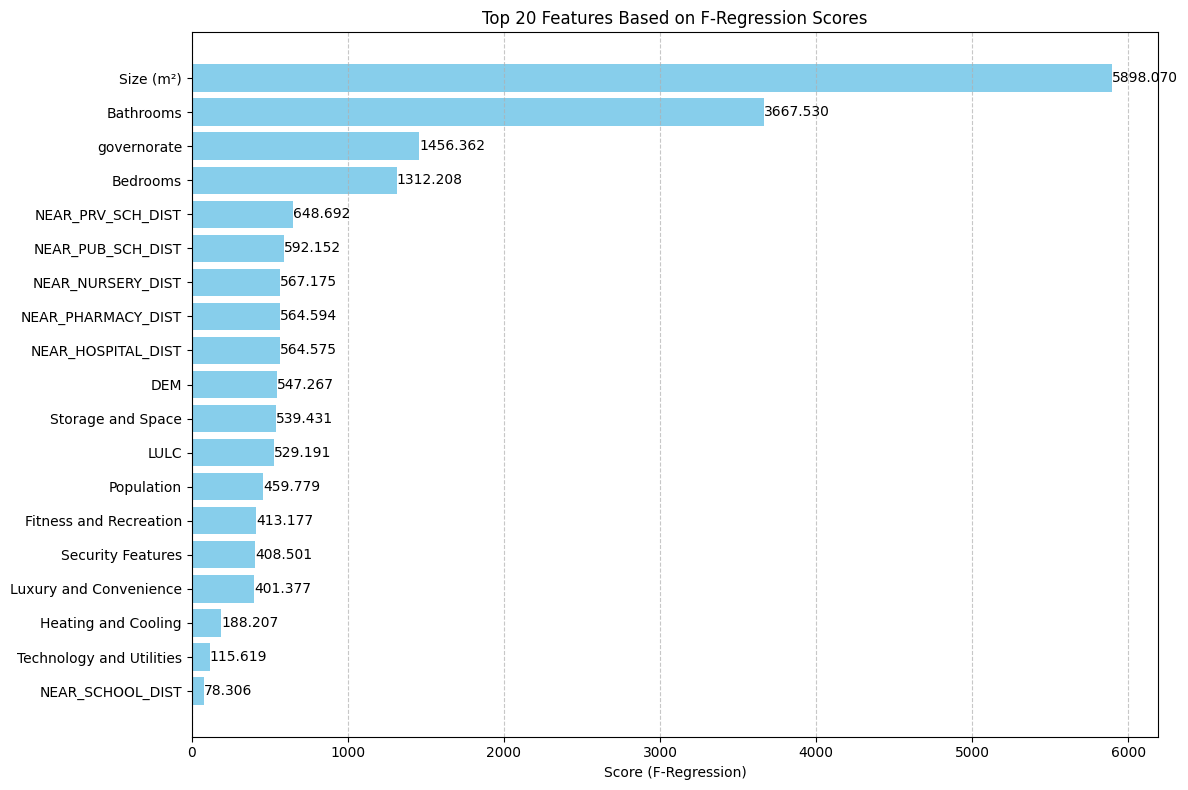

Feature Matrix Shape: (6955, 19)
Target Variable Shape: (6955,)


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

# Save the DataFrame to an Excel file
data.to_excel('/content/drive/Othercomputers/MyMonty Laptop/university M2/M2 final project/Dataset/step 3 - with spatial analysis/FINAL_SELL_REAL_ESTATE_2024-11-17-2.xlsx', index=False)

# Step 5: Calculate the correlation or other metric
X = data.drop(columns=['Price'])
y = data['Price']

# Perform feature selection using f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Create a DataFrame for feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)  # Sort by score for easy ranking

# Step 6: Select the most important 24 features
selected_features = feature_scores.nlargest(19, 'Score')
print("Top 24 Selected Features:")
print(selected_features['Feature'].tolist())

plt.figure(figsize=(12, 8))
bars = plt.barh(selected_features['Feature'], selected_features['Score'], color='skyblue')
plt.xlabel('Score (F-Regression)')
plt.title('Top 20 Features Based on F-Regression Scores')

# Annotate bars with the score values
for bar in bars:
    plt.text(
        bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.3f}', va='center', ha='left'
    )

# Invert y-axis to display the highest score at the top
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Update X to include only the selected features
X = X[selected_features['Feature'].tolist()]

# Check the shapes of X and y
print("Feature Matrix Shape:", X.shape)
print("Target Variable Shape:", y.shape)


## House Price Distribution

Now let us take a look at how the house prices are distributed.

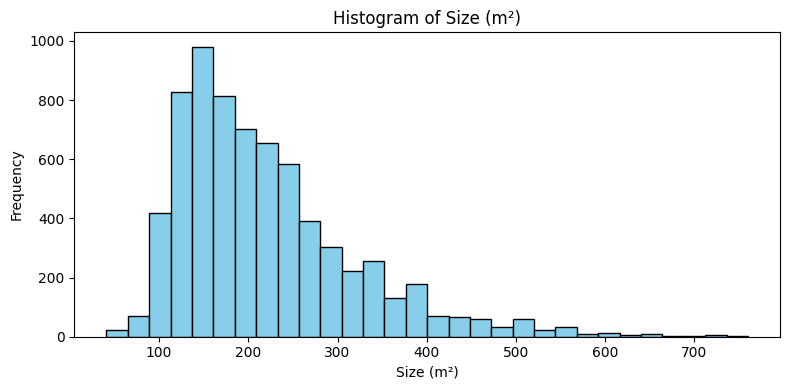

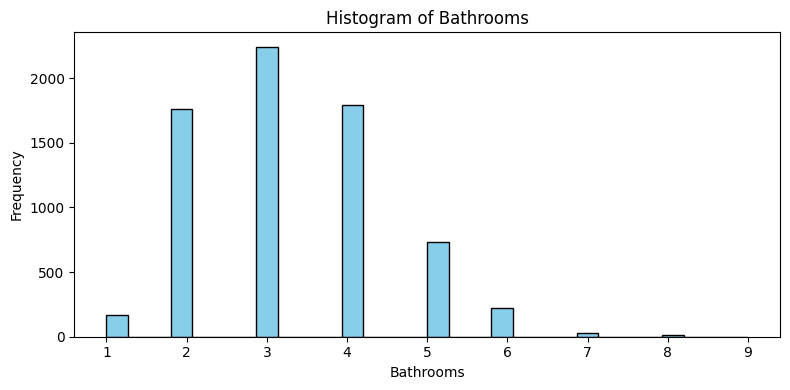

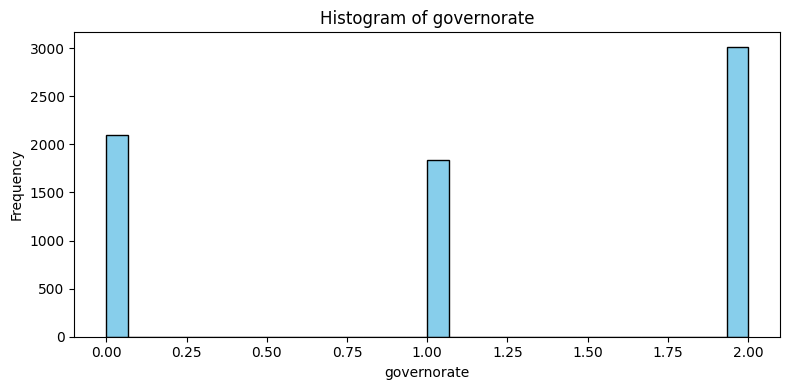

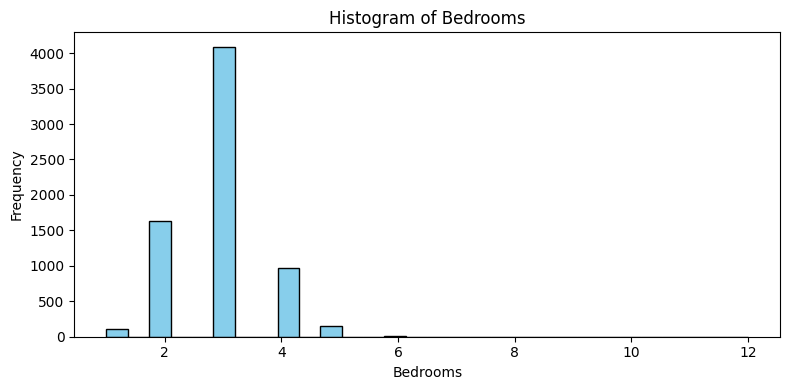

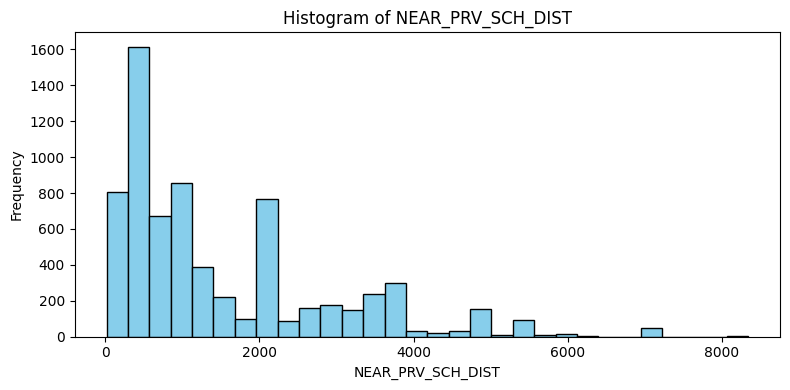

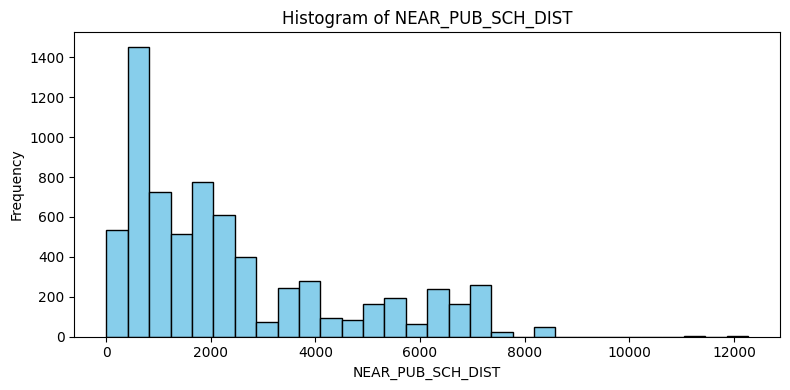

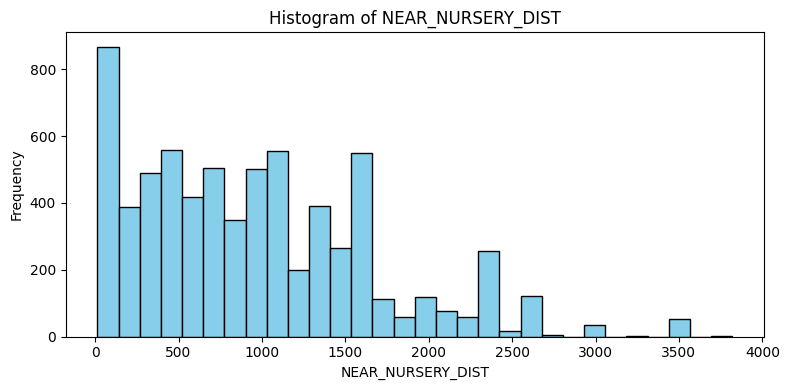

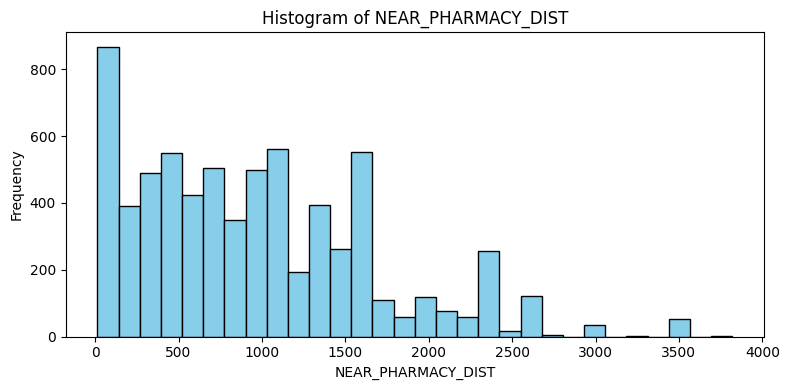

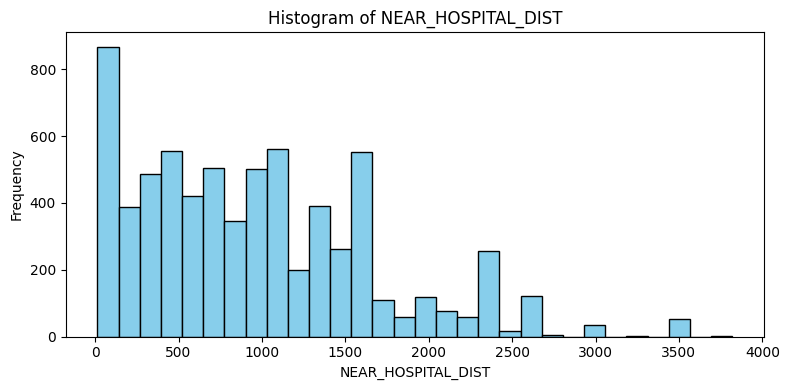

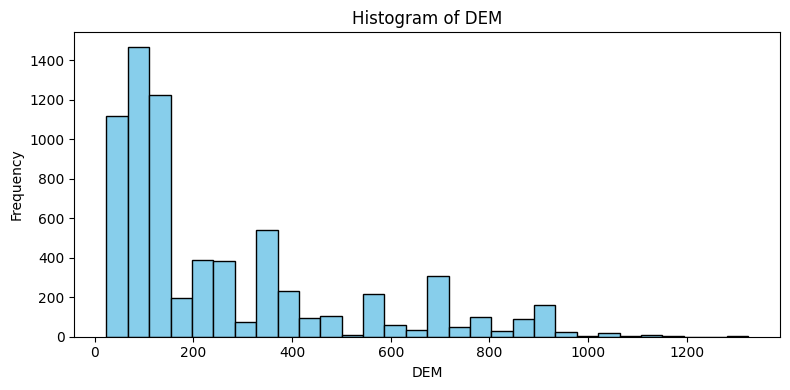

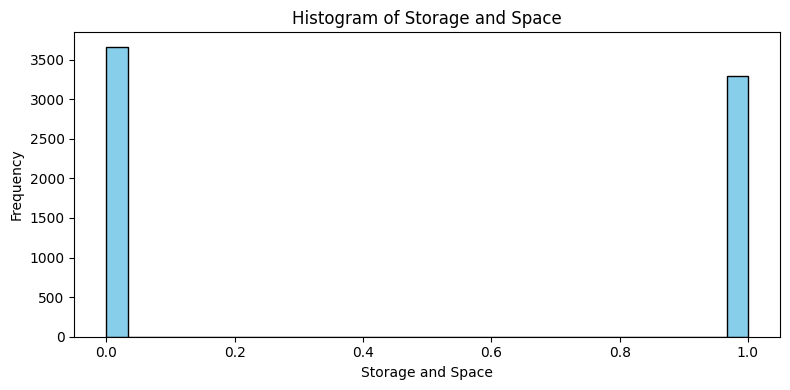

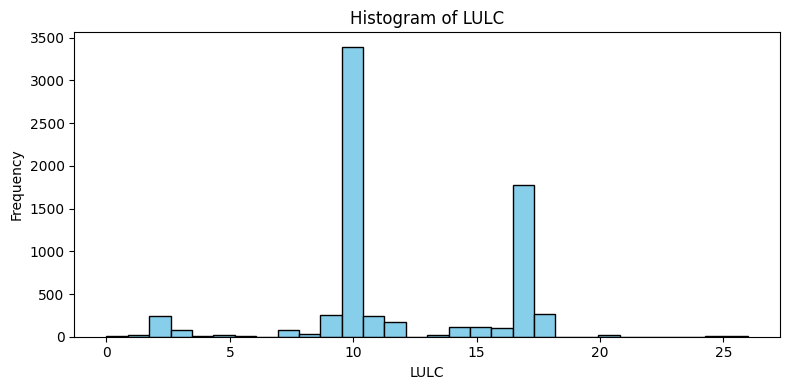

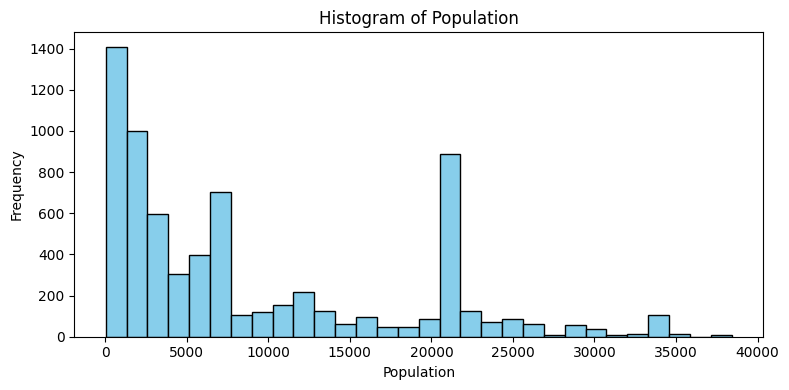

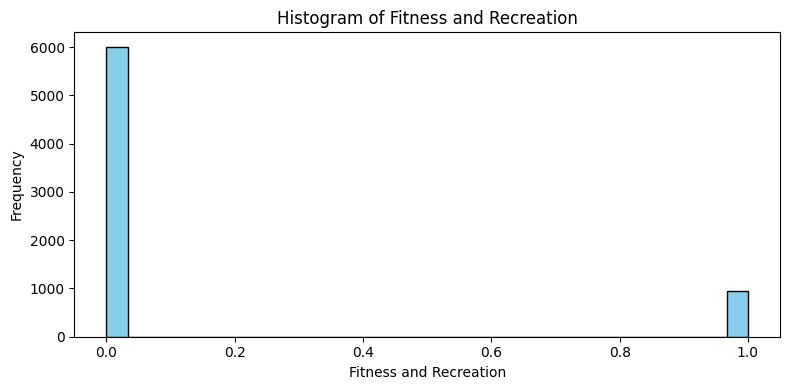

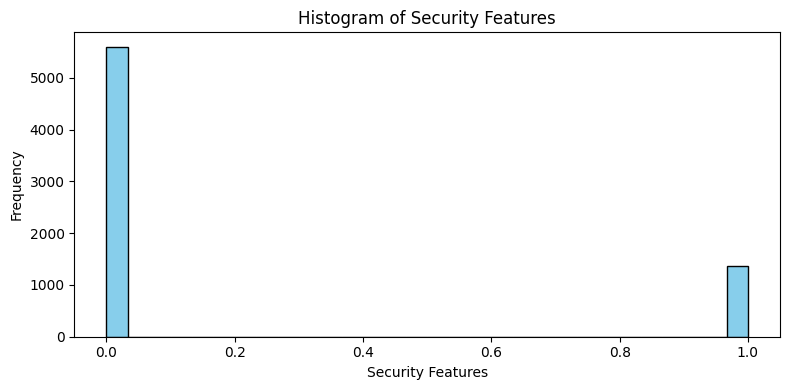

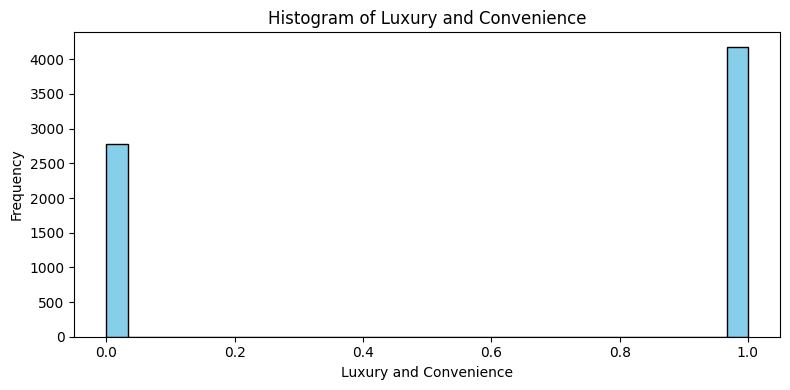

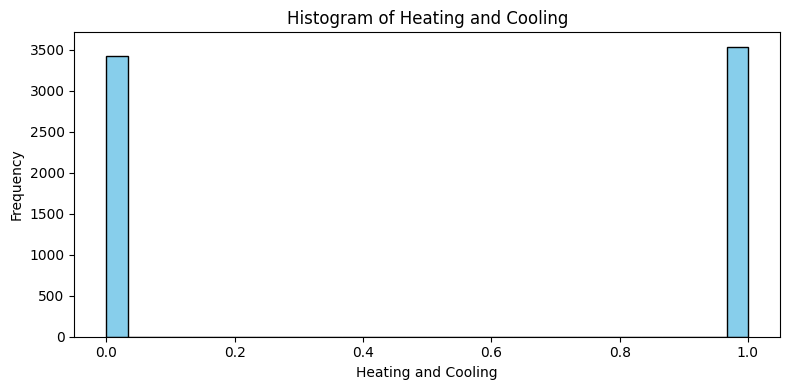

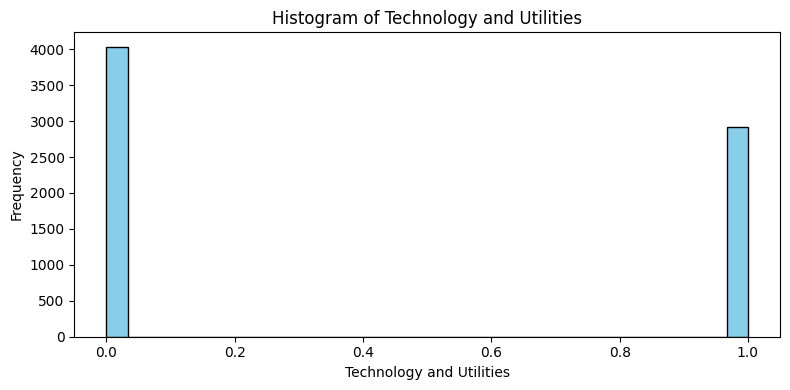

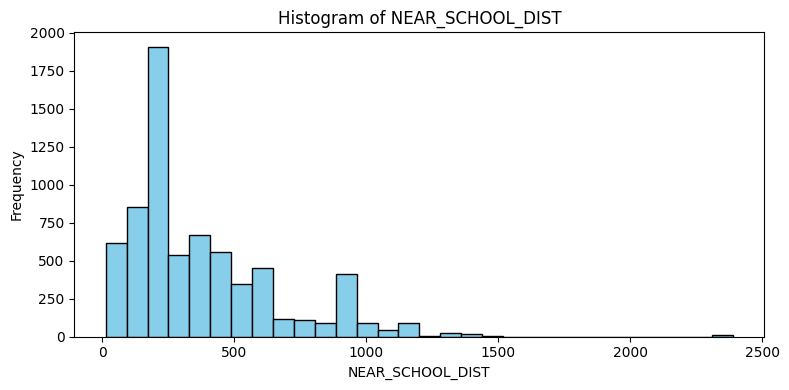

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'data'
for col in X.columns:
    plt.figure(figsize=(8, 4))
    if pd.api.types.is_numeric_dtype(data[col]):
        # Plot histogram for numerical columns
        plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    elif pd.api.types.is_categorical_dtype(data[col]) or data[col].dtype == 'object':
        # Plot bar plot for categorical columns
        sns.countplot(data=data, x=col, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    else:
        # Skip columns with unsupported data types
        print(f"Skipping column: {col} (unsupported data type)")
        continue

    plt.tight_layout()
    plt.show()

count    6.955000e+03
mean     4.319747e+05
std      4.338703e+05
min      4.000000e+04
25%      1.594995e+05
50%      2.700000e+05
75%      5.500000e+05
max      4.500000e+06
Name: Price, dtype: float64


<ipython-input-67-a364fa58e067>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Price'], color='g', bins=100, hist_kws={'alpha': 0.4});


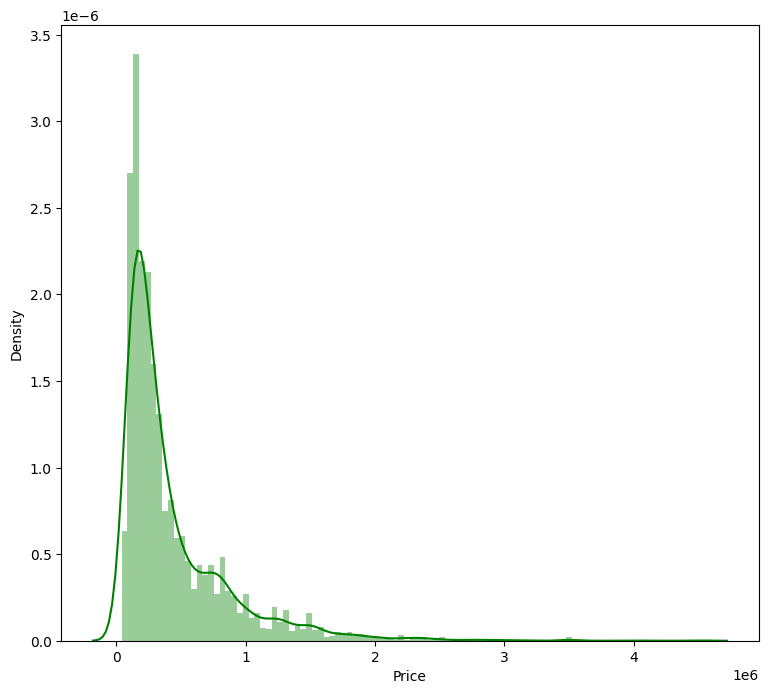

In [ ]:
print(data['Price'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data['Price'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [ ]:
df_num = X.select_dtypes(include=[np.number])

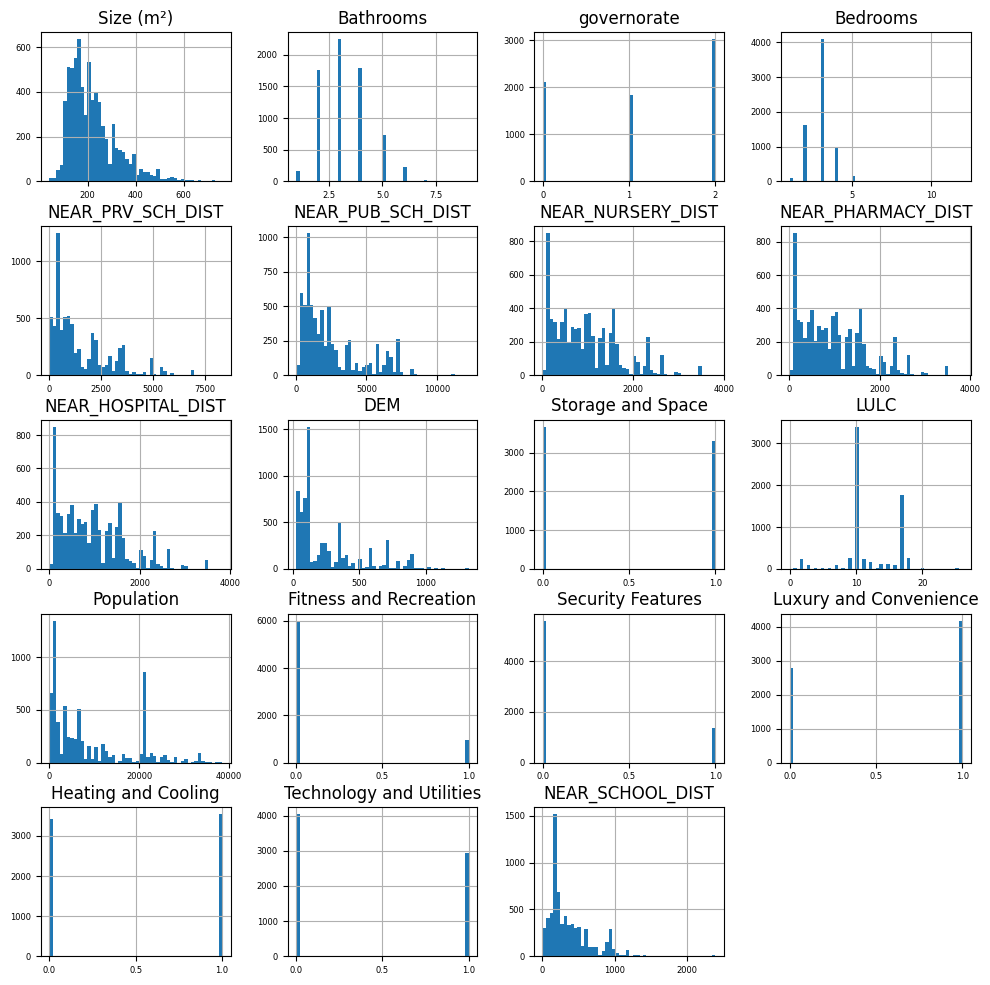

In [ ]:
df_num.hist(figsize=(12, 12), bins=50, xlabelsize=6, ylabelsize=6);

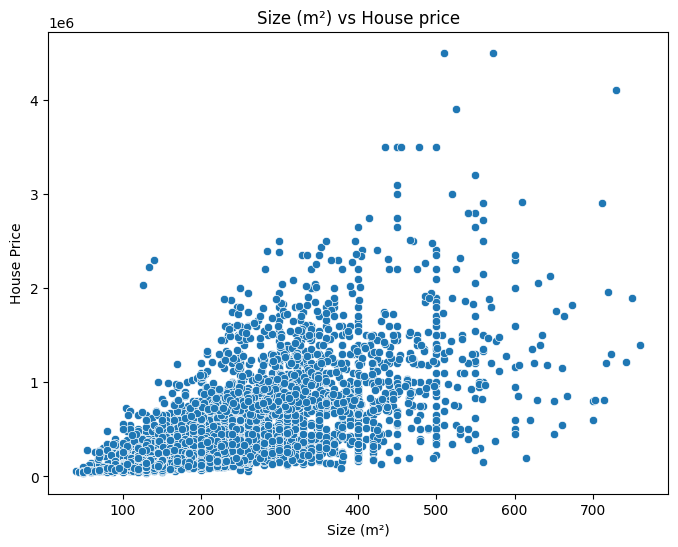

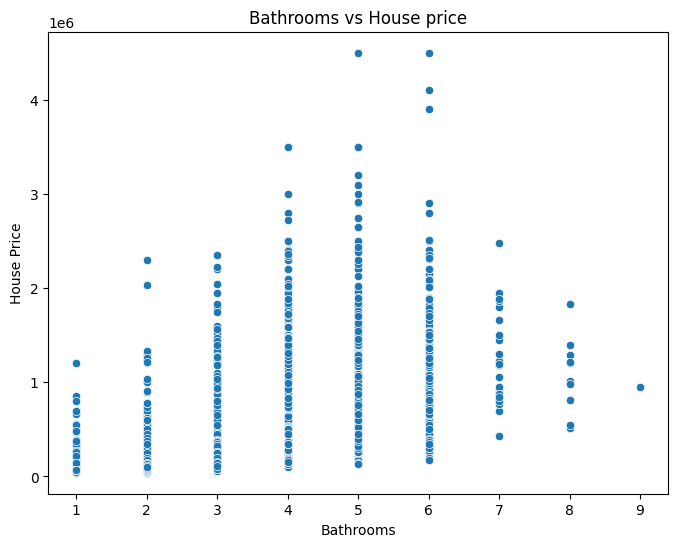

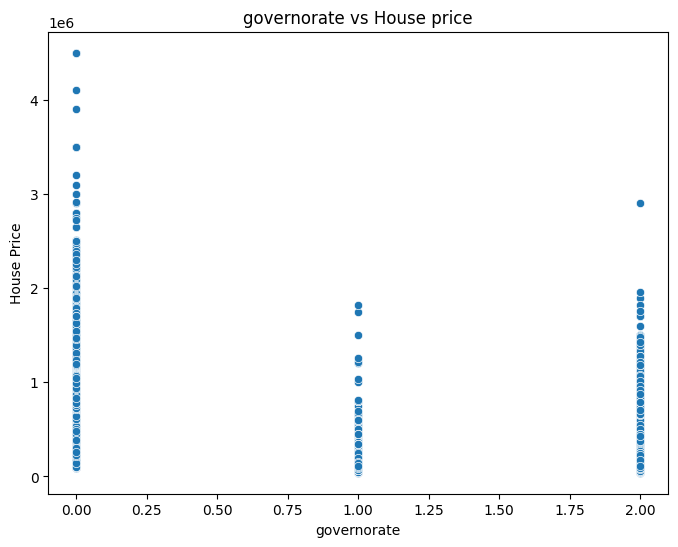

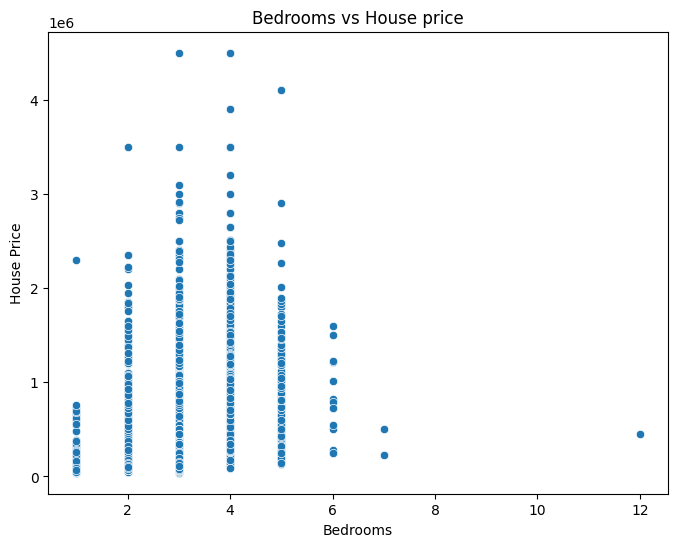

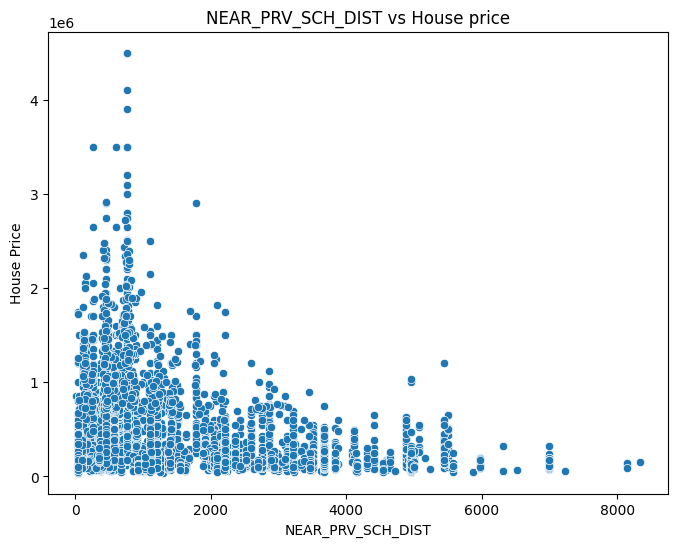

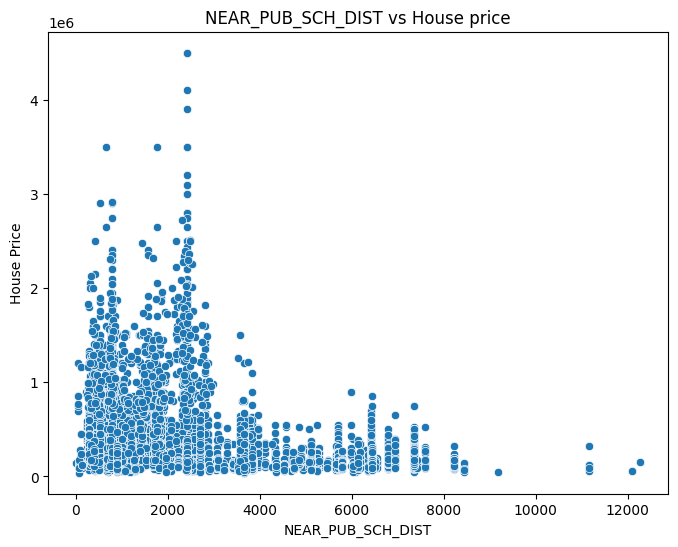

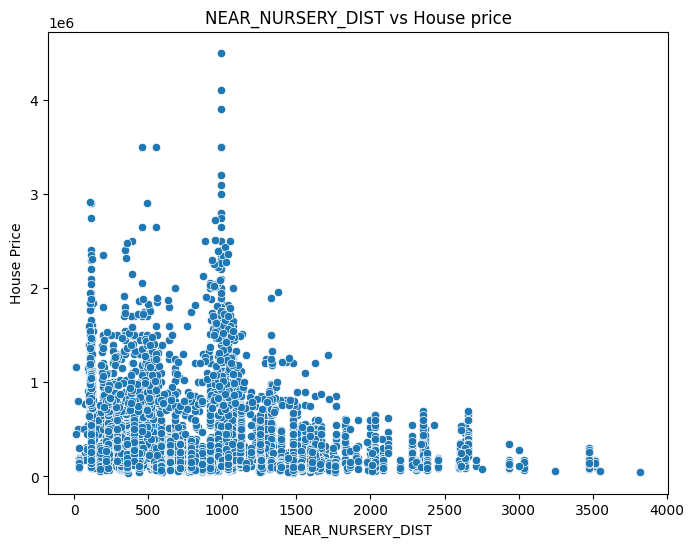

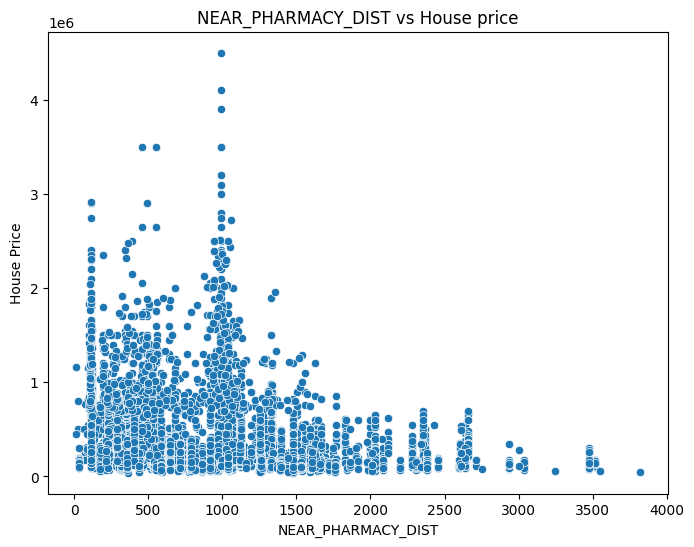

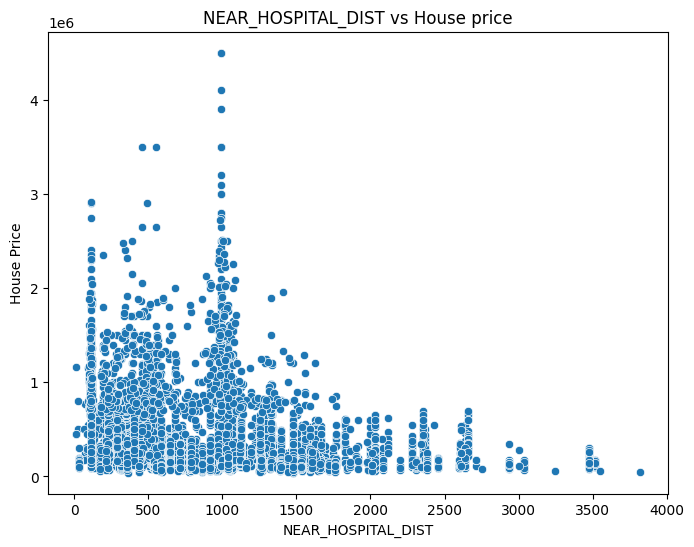

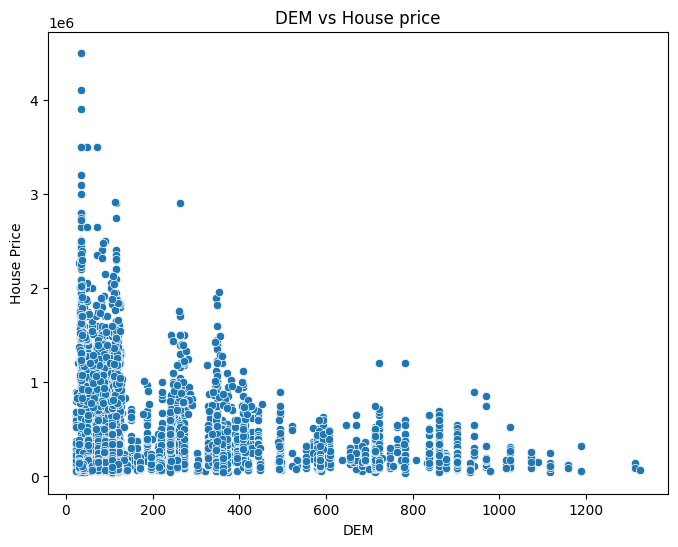

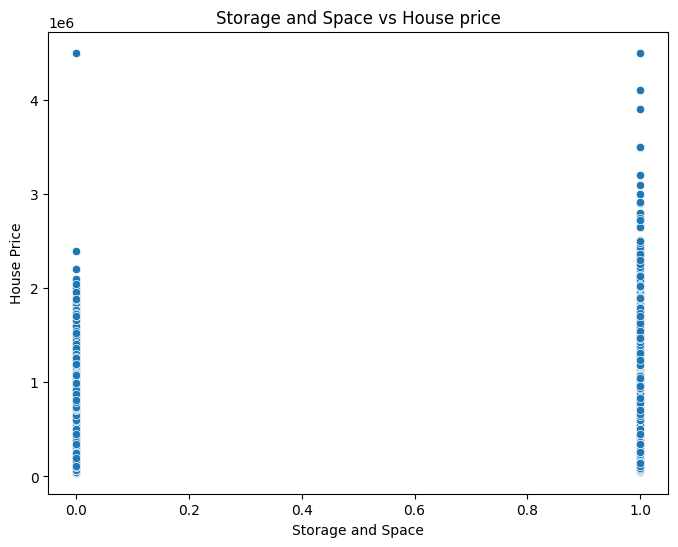

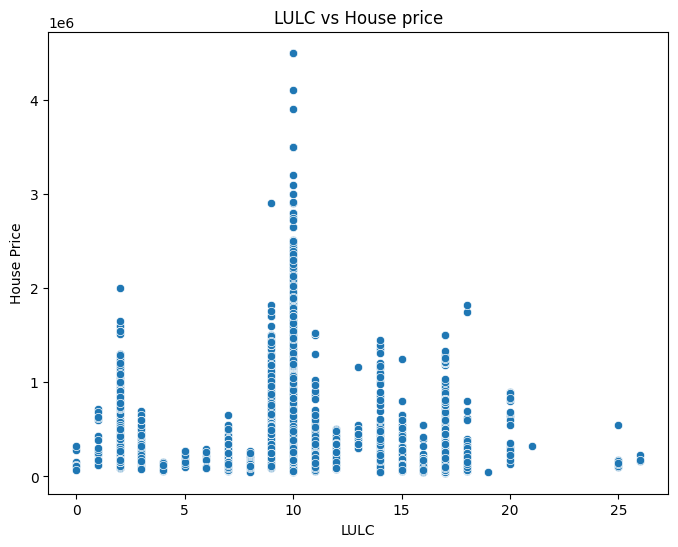

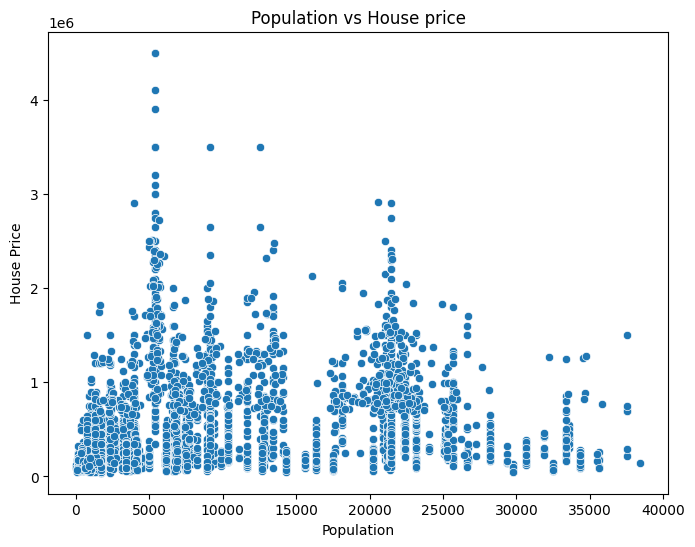

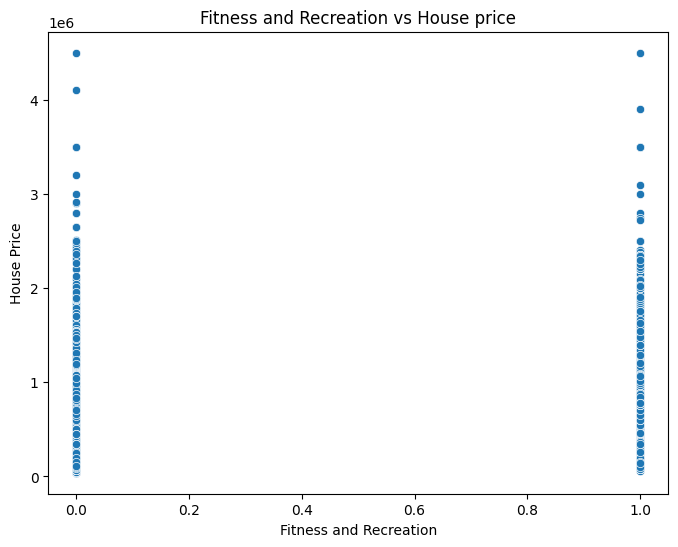

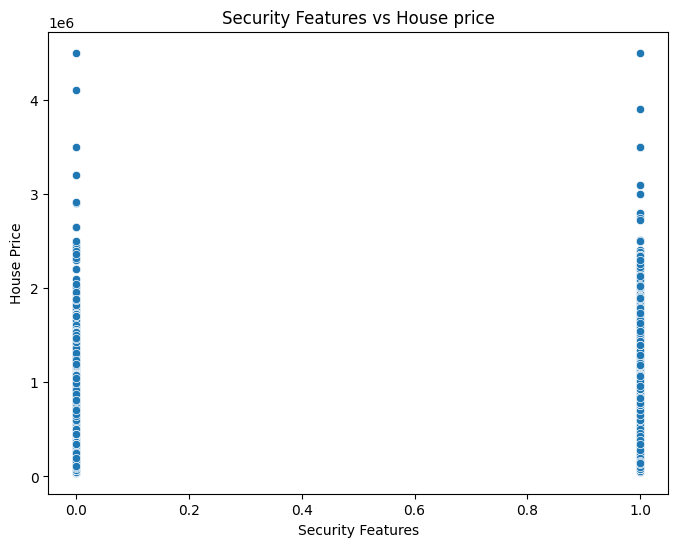

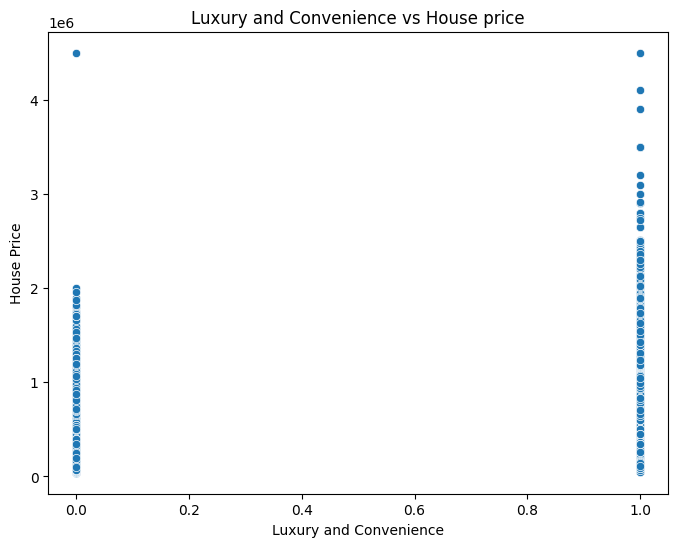

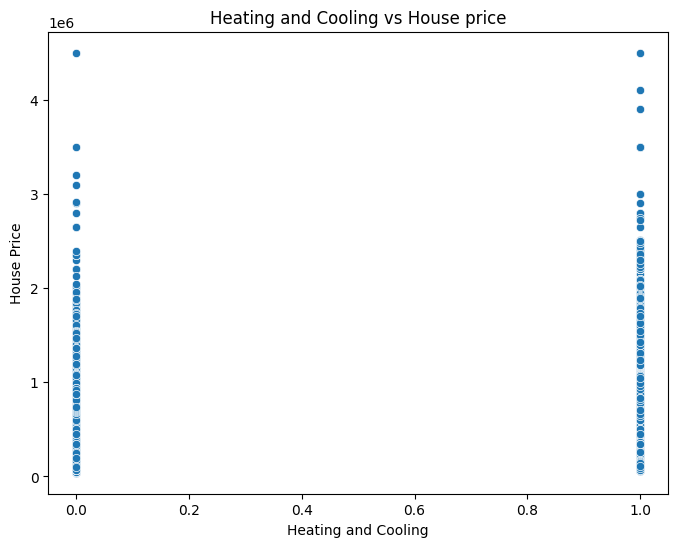

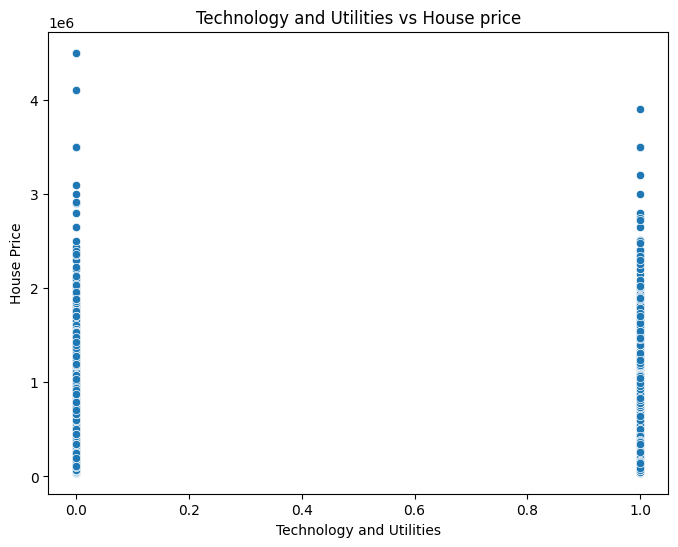

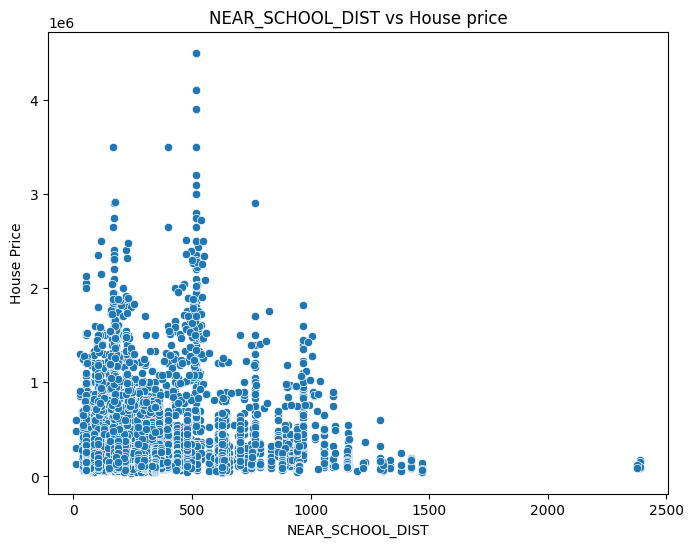

In [ ]:
# Set up subplots for each feature
num_plots = len(df_num)

# Plot each feature against the target
for feature in selected_features['Feature'].tolist():
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.scatterplot(x=feature, y=y, data=X)
    plt.title(f'{feature} vs House price')
    plt.xlabel(feature)
    plt.ylabel('House Price')
    plt.show()


In [ ]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Define regressors
regressors = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=1.0, random_state=42),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42)
}

# Initialize a list to store results
results = []

# Train and evaluate each regressor
for name, reg in regressors.items():
    # Fit the model
    reg.fit(X_train, y_train)

    # Make predictions
    y_pred = reg.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = reg.score(X_test, y_test)

    # Append the results
    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R-squared": r_squared
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

# Display the results
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(


                 Model           MSE           RMSE            MAE  R-squared
0          Extra Trees  2.734122e+10  165351.813668   94133.676426   0.867611
1        Random Forest  3.019421e+10  173764.817798   98357.016889   0.853796
2    Gradient Boosting  3.271524e+10  180873.542999  108058.691490   0.841589
3  K-Nearest Neighbors  4.217728e+10  205371.087741  116518.146166   0.795773
4        Decision Tree  5.794601e+10  240719.783841  129030.648343   0.719418
5                Lasso  6.661763e+10  258103.920975  170033.791228   0.677429
6    Linear Regression  6.672596e+10  258313.684248  170187.081252   0.676905
7                Ridge  6.672669e+10  258315.088924  170178.069173   0.676901
8           ElasticNet  7.275439e+10  269730.216675  171230.319734   0.647714
9             AdaBoost  7.701231e+10  277510.913081  221966.259724   0.627097


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import pandas as pd
# import numpy as np

# # Define regressors and their parameter grids
# param_grids = {
#     "Random Forest": (RandomForestRegressor(random_state=42), {
#         "n_estimators": [100, 200, 500],
#         "max_depth": [None, 10, 20],
#         "min_samples_split": [2, 5, 10],
#         "min_samples_leaf": [1, 2, 4]
#     }),
#     "Extra Trees": (ExtraTreesRegressor(random_state=42), {
#         "n_estimators": [100, 200, 500],
#         "max_depth": [None, 10, 20],
#         "min_samples_split": [2, 5, 10]
#     }),
#     "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {
#         "n_estimators": [100, 200, 500],
#         "learning_rate": [0.01, 0.1, 0.2],
#         "max_depth": [3, 5, 7],
#         "min_samples_split": [2, 5, 10]
#     }),
#     "AdaBoost": (AdaBoostRegressor(random_state=42), {
#         "n_estimators": [50, 100, 200],
#         "learning_rate": [0.01, 0.1, 1.0]
#     }),
#     "Ridge": (Ridge(), {
#         "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
#     }),
#     "Lasso": (Lasso(), {
#         "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
#     }),
#     "ElasticNet": (ElasticNet(random_state=42), {
#         "alpha": [0.001, 0.01, 0.1, 1, 10, 100],
#         "l1_ratio": [0.1, 0.5, 0.9]
#     }),
#     "K-Nearest Neighbors": (KNeighborsRegressor(), {
#         "n_neighbors": [3, 5, 10, 20],
#         "weights": ['uniform', 'distance'],
#         "p": [1, 2]
#     }),
#     "Decision Tree": (DecisionTreeRegressor(random_state=42), {
#         "max_depth": [None, 5, 10, 20],
#         "min_samples_split": [2, 5, 10],
#         "min_samples_leaf": [1, 2, 4]
#     })
# }

# # Initialize a list to store results
# results = []

# # Train and evaluate each regressor using GridSearchCV
# for name, (reg, param_grid) in param_grids.items():
#     print(f"Running GridSearchCV for {name}...")
#     grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid_search.fit(X_train, y_train)

#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_test)

#     # Calculate metrics
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, y_pred)
#     r_squared = best_model.score(X_test, y_test)

#     # Display the result for the current model
#     print(f"\nModel: {name}")
#     print(f"Best Parameters: {grid_search.best_params_}")
#     print(f"MSE: {mse:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"MAE: {mae:.4f}")
#     print(f"R-squared: {r_squared:.4f}\n")

#     # Append the results to the list
#     results.append({
#         "Model": name,
#         "Best Parameters": grid_search.best_params_,
#         "MSE": mse,
#         "RMSE": rmse,
#         "MAE": mae,
#         "R-squared": r_squared
#     })

# # Create a DataFrame to display the results
# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

# # Display the final sorted results
# print("\nModel Performance Results:")
# print(results_df)

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets (example setup)
# Replace X and y with your actual data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for each model
def objective(trial, model_name, return_model=False):
    if model_name == "Random Forest":
        from sklearn.ensemble import RandomForestRegressor
        reg = RandomForestRegressor(
            n_estimators=trial.suggest_categorical("n_estimators", [100, 200, 500]),
            max_depth=trial.suggest_categorical("max_depth", [None, 10, 20]),
            min_samples_split=trial.suggest_categorical("min_samples_split", [2, 5, 10]),
            min_samples_leaf=trial.suggest_categorical("min_samples_leaf", [1, 2, 4]),
            random_state=42
        )
    elif model_name == "Extra Trees":
        from sklearn.ensemble import ExtraTreesRegressor
        reg = ExtraTreesRegressor(
            n_estimators=trial.suggest_categorical("n_estimators", [100, 200, 500]),
            max_depth=trial.suggest_categorical("max_depth", [None, 10, 20]),
            min_samples_split=trial.suggest_categorical("min_samples_split", [2, 5, 10]),
            random_state=42
        )
    elif model_name == "Gradient Boosting":
        from sklearn.ensemble import GradientBoostingRegressor
        reg = GradientBoostingRegressor(
            n_estimators=trial.suggest_categorical("n_estimators", [100, 200, 500]),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_categorical("max_depth", [3, 5, 7]),
            min_samples_split=trial.suggest_categorical("min_samples_split", [2, 5, 10]),
            random_state=42
        )
    elif model_name == "AdaBoost":
        from sklearn.ensemble import AdaBoostRegressor
        reg = AdaBoostRegressor(
            n_estimators=trial.suggest_categorical("n_estimators", [50, 100, 200]),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 1.0),
            random_state=42
        )
    elif model_name == "Ridge":
        from sklearn.linear_model import Ridge
        reg = Ridge(
            alpha=trial.suggest_loguniform("alpha", 0.001, 100)
        )
    elif model_name == "Lasso":
        from sklearn.linear_model import Lasso
        reg = Lasso(
            alpha=trial.suggest_loguniform("alpha", 0.001, 100)
        )
    elif model_name == "ElasticNet":
        from sklearn.linear_model import ElasticNet
        reg = ElasticNet(
            alpha=trial.suggest_loguniform("alpha", 0.001, 100),
            l1_ratio=trial.suggest_float("l1_ratio", 0.1, 0.9),
            random_state=42
        )
    elif model_name == "K-Nearest Neighbors":
        from sklearn.neighbors import KNeighborsRegressor
        reg = KNeighborsRegressor(
            n_neighbors=trial.suggest_categorical("n_neighbors", [3, 5, 10, 20]),
            weights=trial.suggest_categorical("weights", ['uniform', 'distance']),
            p=trial.suggest_categorical("p", [1, 2])
        )
    elif model_name == "Decision Tree":
        from sklearn.tree import DecisionTreeRegressor
        reg = DecisionTreeRegressor(
            max_depth=trial.suggest_categorical("max_depth", [None, 5, 10, 20]),
            min_samples_split=trial.suggest_categorical("min_samples_split", [2, 5, 10]),
            min_samples_leaf=trial.suggest_categorical("min_samples_leaf", [1, 2, 4]),
            random_state=42
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")


    reg.fit(X_train, y_train)

    if return_model:
        return reg  # Return the trained model

    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse  # Optuna minimizes the objective

# Models to optimize
models = ["Random Forest", "Extra Trees", "Gradient Boosting", "AdaBoost",
          "Ridge", "Lasso", "ElasticNet", "K-Nearest Neighbors", "Decision Tree"]

# Results storage
results = []

# Run Optuna for each model
for model_name in models:
    print(f"Optimizing {model_name}...")

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    best_value = study.best_value
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best MSE: {best_value:.4f}")

    # Re-train the model with the best parameters
    trained_model = objective(study.best_trial, model_name, return_model=True)
    y_pred = trained_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = trained_model.score(X_test, y_test)

    results.append({
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R-squared": r_squared,
        "Best Parameters": best_params
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

# Display results
print("\nModel Performance Results:")
print(results_df)

[I 2024-11-27 09:33:49,114] A new study created in memory with name: no-name-84398bd7-be2e-4c78-8eec-ce12ebb6338b


Optimizing Random Forest...


[I 2024-11-27 09:33:53,331] Trial 0 finished with value: 31301198568.297398 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 31301198568.297398.
[I 2024-11-27 09:33:59,629] Trial 1 finished with value: 29021846233.81432 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 29021846233.81432.
[I 2024-11-27 09:34:35,840] Trial 2 finished with value: 29115077052.261673 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 29021846233.81432.
[I 2024-11-27 09:34:40,428] Trial 3 finished with value: 29935606292.609295 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 29021846233.81432.
[I 2024-11-27 09:34:43,488] Trial 4 finished with value: 31373687129.595943 and parameter

Best parameters for Random Forest: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}
Best MSE: 28797212269.1768


[I 2024-11-27 09:41:05,730] A new study created in memory with name: no-name-e361282d-a5f1-4208-994a-3e70853359f7


Optimizing Extra Trees...


[I 2024-11-27 09:41:08,027] Trial 0 finished with value: 29025470429.463436 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10}. Best is trial 0 with value: 29025470429.463436.
[I 2024-11-27 09:41:12,959] Trial 1 finished with value: 26352509741.083492 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}. Best is trial 1 with value: 26352509741.083492.
[I 2024-11-27 09:41:15,249] Trial 2 finished with value: 26645719150.940006 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10}. Best is trial 1 with value: 26352509741.083492.
[I 2024-11-27 09:41:30,191] Trial 3 finished with value: 27204231944.84237 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2}. Best is trial 1 with value: 26352509741.083492.
[I 2024-11-27 09:41:31,760] Trial 4 finished with value: 28750261014.83857 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10}. Best is trial 1 with valu

Best parameters for Extra Trees: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5}
Best MSE: 26333039342.3073


[I 2024-11-27 09:45:38,037] A new study created in memory with name: no-name-b2af40d0-deeb-4b1c-97e4-3813f4ebe292


Optimizing Gradient Boosting...


[I 2024-11-27 09:45:47,805] Trial 0 finished with value: 30109073885.742287 and parameters: {'n_estimators': 500, 'learning_rate': 0.023000210181861727, 'max_depth': 5, 'min_samples_split': 10}. Best is trial 0 with value: 30109073885.742287.
[I 2024-11-27 09:45:51,267] Trial 1 finished with value: 29963773175.76389 and parameters: {'n_estimators': 200, 'learning_rate': 0.06141777479840637, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 1 with value: 29963773175.76389.
[I 2024-11-27 09:45:52,934] Trial 2 finished with value: 29480713781.8548 and parameters: {'n_estimators': 100, 'learning_rate': 0.12505939309306216, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 2 with value: 29480713781.8548.
[I 2024-11-27 09:45:58,458] Trial 3 finished with value: 32141409573.198685 and parameters: {'n_estimators': 500, 'learning_rate': 0.11841588675756679, 'max_depth': 3, 'min_samples_split': 2}. Best is trial 2 with value: 29480713781.8548.
[I 2024-11-27 09:46:05,206] Trial 4 finish

Best parameters for Gradient Boosting: {'n_estimators': 200, 'learning_rate': 0.11854852293413137, 'max_depth': 5, 'min_samples_split': 2}
Best MSE: 28890725673.4459


[I 2024-11-27 09:49:18,833] A new study created in memory with name: no-name-6e1929bb-1e86-4222-8580-7db9762d4071


Optimizing AdaBoost...


[I 2024-11-27 09:49:19,447] Trial 0 finished with value: 58266224317.004555 and parameters: {'n_estimators': 50, 'learning_rate': 0.4066873895464974}. Best is trial 0 with value: 58266224317.004555.
[I 2024-11-27 09:49:20,813] Trial 1 finished with value: 126898890044.77423 and parameters: {'n_estimators': 200, 'learning_rate': 0.7426261512403024}. Best is trial 0 with value: 58266224317.004555.
[I 2024-11-27 09:49:21,364] Trial 2 finished with value: 63152869656.893555 and parameters: {'n_estimators': 50, 'learning_rate': 0.5850440540569679}. Best is trial 0 with value: 58266224317.004555.
[I 2024-11-27 09:49:22,684] Trial 3 finished with value: 50245132389.08857 and parameters: {'n_estimators': 100, 'learning_rate': 0.07303856649190026}. Best is trial 3 with value: 50245132389.08857.
[I 2024-11-27 09:49:23,368] Trial 4 finished with value: 50126937828.07664 and parameters: {'n_estimators': 50, 'learning_rate': 0.05624477393590265}. Best is trial 4 with value: 50126937828.07664.
[I 20

Best parameters for AdaBoost: {'n_estimators': 50, 'learning_rate': 0.08126273958932345}
Best MSE: 47703139635.3952


[I 2024-11-27 09:50:13,566] A new study created in memory with name: no-name-84327b95-0930-435a-919a-a96f013f13ae
<ipython-input-75-ddd192d27a5a>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100)
[I 2024-11-27 09:50:13,581] Trial 0 finished with value: 66725961219.24088 and parameters: {'alpha': 0.0024250404400180284}. Best is trial 0 with value: 66725961219.24088.
<ipython-input-75-ddd192d27a5a>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100)
[I 2024-11-27 09:50:13,597] Trial 1 finished with value: 66729226236.86779 and parameters: {'alpha': 4.411964717646549}. Bes

Optimizing Ridge...


<ipython-input-75-ddd192d27a5a>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100)
[I 2024-11-27 09:50:13,777] Trial 9 finished with value: 66726127749.22643 and parameters: {'alpha': 0.2329564962602761}. Best is trial 2 with value: 66725960605.90026.
<ipython-input-75-ddd192d27a5a>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100)
[I 2024-11-27 09:50:13,830] Trial 10 finished with value: 66726002028.93446 and parameters: {'alpha': 0.05897812459287799}. Best is trial 2 with value: 66725960605.90026.
<ipython-input-75-ddd192d27a5a>:50: FutureWarning: suggest_loguniform 

Best parameters for Ridge: {'alpha': 0.001012826869787857}
Best MSE: 66725960200.5194
Optimizing Lasso...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
[I 2024-11-27 09:50:15,635] Trial 0 finished with value: 66617840396.047104 and parameters: {'alpha': 2.855047145447336}. Best is trial 0 with value: 66617840396.047104.
<ipython-input-75-ddd192d27a5a>:55: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

Best parameters for Lasso: {'alpha': 0.001011692032192368}
Best MSE: 66617523022.2907
Optimizing ElasticNet...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
[I 2024-11-27 09:50:24,703] Trial 0 finished with value: 69674920577.41077 and parameters: {'alpha': 1.3700337795007278, 'l1_ratio': 0.8173482228941725}. Best is trial 0 with value: 69674920577.41077.
<ipython-input-75-ddd192d27a5a>:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha=trial.suggest_loguniform("alpha", 0.001, 100),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to

Best parameters for ElasticNet: {'alpha': 0.0021565011403635115, 'l1_ratio': 0.8822100497305602}
Best MSE: 66618410790.1485


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
[I 2024-11-27 09:50:33,052] A new study created in memory with name: no-name-89bb1a3e-61d2-4a50-af60-061310b18298


Optimizing K-Nearest Neighbors...


[I 2024-11-27 09:50:33,495] Trial 0 finished with value: 40169277561.09318 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 40169277561.09318.
[I 2024-11-27 09:50:33,934] Trial 1 finished with value: 41639959895.84315 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 40169277561.09318.
[I 2024-11-27 09:50:34,056] Trial 2 finished with value: 43774880369.60447 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 40169277561.09318.
[I 2024-11-27 09:50:34,465] Trial 3 finished with value: 50376572043.74256 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 40169277561.09318.
[I 2024-11-27 09:50:34,887] Trial 4 finished with value: 39053735125.50322 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 39053735125.50322.
[I 2024-11-27 09:50:35,002] Trial 5 finished with valu

Best parameters for K-Nearest Neighbors: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}
Best MSE: 38545499077.0635


[I 2024-11-27 09:50:46,353] A new study created in memory with name: no-name-0fc0f3bf-7cac-47ab-8027-85bb0d822441
[I 2024-11-27 09:50:46,395] Trial 0 finished with value: 39778275019.69888 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,442] Trial 1 finished with value: 46340173315.50398 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,482] Trial 2 finished with value: 39778275019.69888 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,545] Trial 3 finished with value: 57946014332.61967 and parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 39778275019.69888.


Optimizing Decision Tree...


[I 2024-11-27 09:50:46,594] Trial 4 finished with value: 41229819385.14491 and parameters: {'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,635] Trial 5 finished with value: 43992195990.71694 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,694] Trial 6 finished with value: 53008269573.966156 and parameters: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,743] Trial 7 finished with value: 42332311291.74642 and parameters: {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 39778275019.69888.
[I 2024-11-27 09:50:46,795] Trial 8 finished with value: 50593692078.91866 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 wi

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}
Best MSE: 39778275019.6989

Model Performance Results:
                 Model           MSE           RMSE            MAE  R-squared  \
0          Extra Trees  2.633304e+10  162274.580087   92397.104771   0.872492   
1        Random Forest  2.879721e+10  169697.413855   96723.733127   0.860560   
2    Gradient Boosting  2.889073e+10  169972.720380   98452.143705   0.860108   
3  K-Nearest Neighbors  3.854550e+10  196330.076853  108815.918567   0.813358   
4        Decision Tree  3.977828e+10  199444.917257  114114.332568   0.807389   
5             AdaBoost  4.770314e+10  218410.484262  146155.359797   0.769016   
6                Lasso  6.661752e+10  258103.705945  170034.112409   0.677430   
7           ElasticNet  6.661841e+10  258105.425728  170023.116584   0.677426   
8                Ridge  6.672596e+10  258313.685662  170187.072120   0.676905   

                                  

In [ ]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

# Step 1: Prepare base models for ensemble methods using the best parameters
model_instances = []
for res in results:
    model_name = res["Model"]
    best_params = res["Best Parameters"]

    if model_name == "Random Forest":
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(random_state=42, **best_params)
    elif model_name == "Extra Trees":
        from sklearn.ensemble import ExtraTreesRegressor
        model = ExtraTreesRegressor(random_state=42, **best_params)
    elif model_name == "Gradient Boosting":
        from sklearn.ensemble import GradientBoostingRegressor
        model = GradientBoostingRegressor(random_state=42, **best_params)
    elif model_name == "AdaBoost":
        from sklearn.ensemble import AdaBoostRegressor
        model = AdaBoostRegressor(random_state=42, **best_params)
    elif model_name == "Ridge":
        from sklearn.linear_model import Ridge
        model = Ridge(**best_params)
    elif model_name == "Lasso":
        from sklearn.linear_model import Lasso
        model = Lasso(**best_params)
    elif model_name == "ElasticNet":
        from sklearn.linear_model import ElasticNet
        model = ElasticNet(random_state=42, **best_params)
    elif model_name == "K-Nearest Neighbors":
        from sklearn.neighbors import KNeighborsRegressor
        model = KNeighborsRegressor(**best_params)
    elif model_name == "Decision Tree":
        from sklearn.tree import DecisionTreeRegressor
        model = DecisionTreeRegressor(random_state=42, **best_params)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    model_instances.append((model_name, clone(model)))

# Step 2: Define Voting Regressor
voting_regressor = VotingRegressor(estimators=model_instances)

# Train Voting Regressor
voting_regressor.fit(X_train, y_train)
y_pred_voting = voting_regressor.predict(X_test)

# Calculate metrics
mse_voting = mean_squared_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mse_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r_squared_voting = voting_regressor.score(X_test, y_test)

results.append({
    "Model": "Voting Regressor",
    "MSE": mse_voting,
    "RMSE": rmse_voting,
    "MAE": mae_voting,
    "R-squared": r_squared_voting,
    "Best Parameters": "Combined"
})

# Step 3: Define Stacking Regressor
# Using Linear Regression as the final estimator
final_estimator = LinearRegression()
stacking_regressor = StackingRegressor(estimators=model_instances, final_estimator=final_estimator)

# Train Stacking Regressor
stacking_regressor.fit(X_train, y_train)
y_pred_stacking = stacking_regressor.predict(X_test)

# Calculate metrics
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r_squared_stacking = stacking_regressor.score(X_test, y_test)

results.append({
    "Model": "Stacking Regressor",
    "MSE": mse_stacking,
    "RMSE": rmse_stacking,
    "MAE": mae_stacking,
    "R-squared": r_squared_stacking,
    "Best Parameters": "Combined"
})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)

# Display results
print("\nModel Performance Results:")
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+14, tolerance: 8.771e


Model Performance Results:
                  Model           MSE           RMSE            MAE  \
0    Stacking Regressor  2.565955e+10  160185.977884   91609.575888   
1           Extra Trees  2.633304e+10  162274.580087   92397.104771   
2         Random Forest  2.879721e+10  169697.413855   96723.733127   
3     Gradient Boosting  2.889073e+10  169972.720380   98452.143705   
4      Voting Regressor  3.348482e+10  182988.592362  111952.392475   
5   K-Nearest Neighbors  3.854550e+10  196330.076853  108815.918567   
6         Decision Tree  3.977828e+10  199444.917257  114114.332568   
7              AdaBoost  4.770314e+10  218410.484262  146155.359797   
8                 Lasso  6.661752e+10  258103.705945  170034.112409   
9            ElasticNet  6.661841e+10  258105.425728  170023.116584   
10                Ridge  6.672596e+10  258313.685662  170187.072120   

    R-squared                                    Best Parameters  
0    0.875753                                       

In [ ]:
# Create a Gradient Boosting Regressor model
# gb_model = ExtraTreesRegressor(
#     max_depth=20,
#     min_samples_split=5,
#     n_estimators=500,
#     random_state=42,  # For reproducibility
#     n_jobs=-1         # Utilize all CPU cores for training
# )
gb_model = stacking_regressor
# gb_model = KNeighborsRegressor(
#     n_neighbors=5,  # Number of neighbors
#     p=2,            # Minkowski distance metric (p=2 corresponds to Euclidean distance)
#     weights='distance'  # Weight by distance (closer neighbors have higher influence)
# )

# Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}
# Train the model on the training data
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r_squared = gb_model.score(X_test, y_test)

# print(name)
print("Mean Squared Error:", mse)
print("R-squared:", r_squared)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+14, tolerance: 8.771e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e+14, tolerance: 6.659e

Mean Squared Error: 25659547510.677505
R-squared: 0.8757533797695092


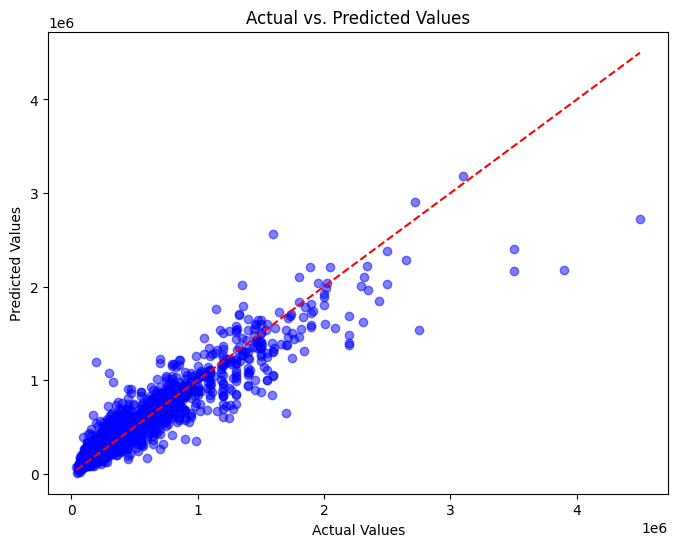

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Add labels and title
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Add a diagonal line representing perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Show plot
plt.show()


## Save the model

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn
import joblib
print(sklearn.__version__)
print(joblib.__version__)

1.5.2
1.4.2


In [ ]:
import joblib

# Define the path in your Google Drive where you want to save the model
model_path = "/content/drive/MyDrive/university M2/M2 final project/finalModel/"

# Save the model to a file
joblib.dump(gb_model, f'{model_path}StackingRegressor2.pkl')

['/content/drive/MyDrive/university M2/M2 final project/finalModel/StackingRegressor2.pkl']

In [ ]:
# Load the model from the file
loaded_model = joblib.load(f'{model_path}ExtraTreesRegressor.pkl')

In [ ]:
print(X_valid.iloc[22])
print(y_valid.iloc[22])

NameError: name 'X_valid' is not defined

In [ ]:
# y_pred = loaded_model.predict(X_valid.iloc[[22]])
y_pred = loaded_model.predict(X_valid)
print(y_pred)

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# Print results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")